<a href="https://colab.research.google.com/github/rjimpervious/covid_predictor/blob/main/covid_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Import tools needed
import datetime
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib inline

from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMAResults

from math import sqrt

import warnings

#Preparing Data

In [3]:
df = pd.read_csv("drive/MyDrive/covid_predictor/covid_de.csv", parse_dates=["date"])

In [4]:
df = df.groupby(by="date").sum()

In [9]:
# Get the location of 2020/02/24 because we will use that as a starting point
base = df.index.get_loc('2020-02-24')
base


17

Now start at index 17

In [10]:
# Get the sum of the cases until to index 16
df["cases"][:17].sum()

29

In [11]:
# Now start at index 16
df = df[17:]

In [15]:
df.head()

,cases,deaths,recovered
date,,,
2020-02-24,29,29,29
2020-02-25,3,0,3
2020-02-26,7,0,7
2020-02-27,24,0,24
2020-02-28,48,0,48


In [14]:
# change to value of index 0 (previously index 6) to sum of the previous values
df.iloc[0] = 29

In [16]:
del df["deaths"]

In [17]:
del df["recovered"]

In [18]:
df.head()

,cases
date,
2020-02-24,29
2020-02-25,3
2020-02-26,7
2020-02-27,24
2020-02-28,48


# Now plot the current DataFrame

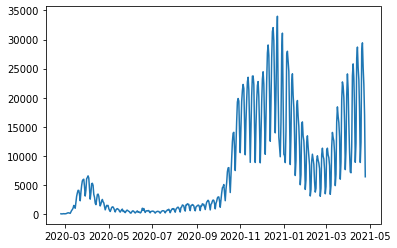

In [19]:
plt.plot(df);

In [20]:
# Set frequency of index as 'd' (day) ( this is required for ARIMA mode)
df = df.asfreq('d')

# GridSearch (Exhaustive Searching) the best parameters for ARIMA model

In [21]:


# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))


# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(df.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=12067.075
ARIMA(0, 0, 1) RMSE=6673.250
ARIMA(0, 1, 0) RMSE=5392.773
ARIMA(0, 1, 1) RMSE=4331.286
ARIMA(0, 2, 0) RMSE=5988.589
ARIMA(0, 2, 1) RMSE=5882.512
ARIMA(0, 2, 2) RMSE=4347.635
ARIMA(1, 0, 0) RMSE=5285.759
ARIMA(1, 0, 1) RMSE=4156.787
ARIMA(1, 1, 0) RMSE=5028.834
ARIMA(1, 1, 1) RMSE=4454.296
ARIMA(1, 2, 0) RMSE=6004.929
ARIMA(2, 0, 0) RMSE=4776.893
ARIMA(2, 0, 1) RMSE=4266.678
ARIMA(2, 1, 0) RMSE=4137.363
ARIMA(2, 1, 1) RMSE=3631.378
ARIMA(2, 2, 0) RMSE=5211.444
ARIMA(4, 0, 0) RMSE=4120.000
ARIMA(4, 1, 0) RMSE=3231.223
ARIMA(4, 1, 1) RMSE=2890.744
ARIMA(4, 2, 0) RMSE=4814.619
ARIMA(6, 0, 0) RMSE=2592.468
ARIMA(6, 1, 1) RMSE=2579.808
Best ARIMA(6, 1, 1) RMSE=2579.808


# Now test the models with the best parameters

predicted=19048.736566, expected19248.000000
predicted=22726.804718, expected23206.000000
predicted=23775.798935, expected24457.000000
predicted=21492.782817, expected22292.000000
predicted=16840.792180, expected15717.000000
predicted=9660.795312, expected10261.000000
predicted=13202.679328, expected16466.000000
predicted=21475.704213, expected22838.000000
predicted=25381.677292, expected27684.000000
predicted=27340.884395, expected29070.000000
predicted=24702.325714, expected27300.000000
predicted=19433.792249, expected20644.000000
predicted=13459.142927, expected12509.000000
predicted=14937.688862, expected19084.000000
predicted=25296.407579, expected26929.000000
predicted=30322.236005, expected31372.000000
predicted=31224.397718, expected32055.000000
predicted=28680.473860, expected29786.000000
predicted=22628.908816, expected21751.000000
predicted=13784.358891, expected13947.000000
predicted=18447.252263, expected20370.000000
predicted=27793.103567, expected29012.000000
predicted=3

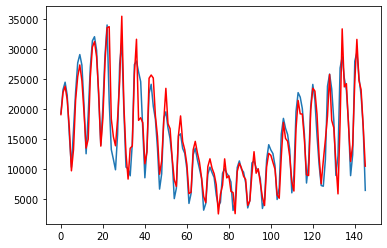

In [22]:


X = df.values
size = int(len(X)*0.66)
train, test = X[0:size], X[size: len(X)]
history = [x for x in train]
predictions = []
#walk forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(6, 1, 1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs=test[t]
    history.append(obs)
    print('predicted=%f, expected%f' %(yhat, obs))

# evaluate forecasts
warnings.filterwarnings("ignore")
rmse = sqrt(mean_squared_error(test, predictions))
print("Test RMSE: {:.3f}".format(rmse))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

#Now fit the model with the best parameters

In [23]:
model = ARIMA(df, order=(6, 1, 1))

In [24]:
model_fit = model.fit()

# Now Make predictions

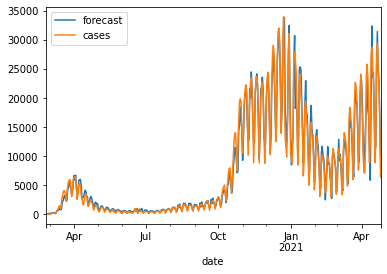

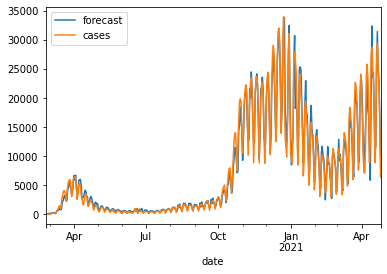

In [25]:
model_fit.plot_predict()

In [26]:
# Make a 14 day forecast
forecast = model_fit.forecast(steps=14)[0]
forecast

array([10277.28768842, 24753.59924476, 28942.1081595 , 26021.9425376 ,
       22779.03427681, 17010.67061087,  8610.93372251, 11822.1471734 ,
       22971.95442611, 28172.99181589, 26488.85735696, 23265.25791226,
       17283.09522587, 10564.16743622])

In [27]:
df.tail()

,cases
date,
2021-04-21,29432
2021-04-22,25250
2021-04-23,22288
2021-04-24,17003
2021-04-25,6396


In [28]:
# Making forecast dataframe
forecast_dates = pd.date_range(start='2021-04-26', periods=14, freq='d')
forecast_df = pd.DataFrame(forecast, index=forecast_dates, columns=["cases"])

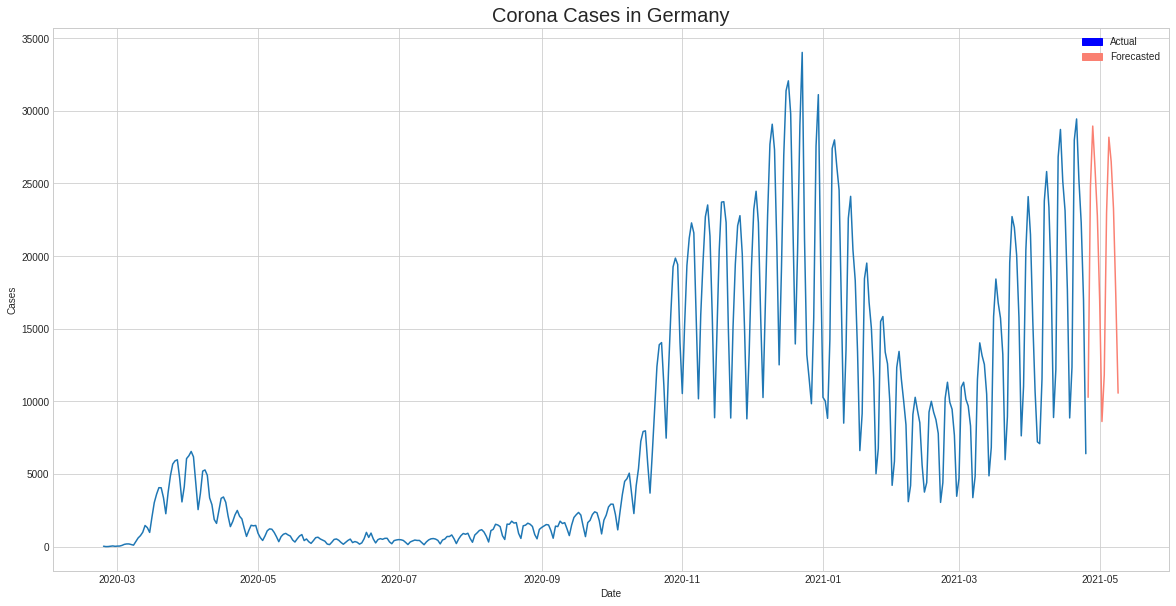

In [29]:
import matplotlib.patches as mpatches
plt.style.use('seaborn-whitegrid')

plt.figure(figsize=(20, 10))
plt.plot(df)
plt.plot(forecast_df, color="salmon");

plt.xlabel("Date", fontsize=10)
plt.ylabel("Cases", fontsize=10)
plt.title("Corona Cases in Germany", fontsize=20)

actual = mpatches.Patch(color='blue', label='Actual')
forecasted = mpatches.Patch(color='salmon', label='Forecasted')
plt.legend(handles=[actual, forecasted]);



In [30]:
model_fit.save("drive/MyDrive/covid_predictor/models/model.pkl")

In [ ]:
df.head()

,cases
date,
2020-02-24,7
2020-02-25,3
2020-02-26,7
2020-02-27,24
2020-02-28,48


In [31]:
df.to_pickle("drive/MyDrive/covid_predictor/dataframe.pkl")